In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
## import trajectory data
df = pd.read_csv('trajectory.csv')
df.head()
# df to numpy array
data = df.to_numpy()
data.shape
trajectory = np.delete(data, 2, 1)
trajectory = np.delete(trajectory, -1, 1)
trajectory.shape

(9999, 4)

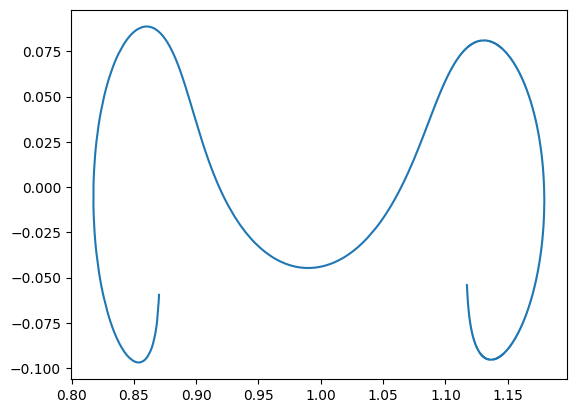

In [83]:
plt.plot(trajectory[:,0], trajectory[:,1])

In [84]:
# three body problem env
import gym
from gym import spaces
from stable_baselines3 import PPO, DDPG
import numpy as np

class three_body_env(gym.Env):
    def __init__(self, trajectory):
        self.trajectory = trajectory
        self.state = np.zeros(4)
        self.dt = 0.01
        self.mu = 0.012277471
        self.action_space = spaces.Box(low=-1, high=1, shape=(2,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-1, high=1, shape=(4,), dtype=np.float32)
        self.position = trajectory[0]
        self.steps = 0
        self.max_steps = 1000
        self.reward_range = (-float('inf'), float('inf'))
        self.reset()

    def step(self, action):
        x = self.position[0]
        y = self.position[1]
        xdot = self.position[2]
        ydot = self.position[3]

        a_x = action[0]
        a_y = action[1]

        r1 = np.sqrt((x+self.mu)**2 + y**2)
        r2 = np.sqrt((x-1+self.mu)**2 + y**2)

        xddot = 2*ydot + x -(1-self.mu)*((x+self.mu)/(r1**3)) - self.mu*(x-1+self.mu)/(r2**3) + a_x
        yddot = -2*xdot + y - (1-self.mu)*(y/(r1**3)) - self.mu*(y)/(r2**3) + a_y

        x = x + xdot*self.dt
        y = y + ydot*self.dt
        
        xdot = xdot + xddot*self.dt
        ydot = ydot + yddot*self.dt

        self.position = np.array([x, y, xdot, ydot])

        self.steps += 1

        self.position2state()

        reward = 1 - np.linalg.norm(self.position - self.trajectory[self.steps], axis=0)
        done = self.steps >= self.max_steps
        if abs(self.position - self.trajectory[-1]).sum() < 0.005:
            done = True
            reward = 100
        if self.steps > 2:
            done = True
            reward = -100

        return self.state, reward, done, self.position

    def position2state(self):
        # find nearest point from position to trajectory
        distance = np.linalg.norm(self.trajectory - self.position, axis=1)
        nearest_idx = np.argmin(distance)
        # estate = position - nearest(index)
        self.state = self.position - self.trajectory[nearest_idx]
    
    def reset(self):
        self.position = self.trajectory[0]   
        self.steps = 0
        self.position2state()
        return self.state
    
    def render(self):
        pass

    def close(self):
        pass

    



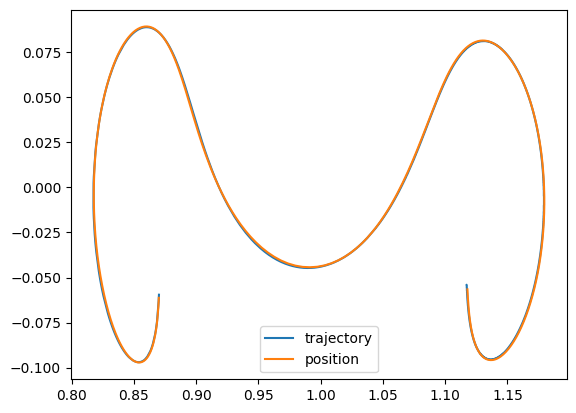

In [80]:
env = three_body_env(trajectory)
env.reset()
# save position
position_array = []
# using PD Guidance
for i in range(600):
    action = -120 * env.state[2:] - 70 * env.state[:2]
    # print(action)
    state, reward, done, position = env.step(action)
    position_array.append(position)
    if done:
        break
plt.plot(trajectory[:,0], trajectory[:,1])
plt.plot(np.array(position_array)[:,0], np.array(position_array)[:,1])
# legned
plt.legend(['trajectory', 'position'])
plt.show()
